# GMX Price Analysis Using `eth_defi`'s native `GMX` Integration

This tutorial demonstrates how to analyze GMX token prices using OHLC (Open, High, Low, Close) candlestick data combined with on-chain TVL and Open Interest data.

## Overview

GMX is a decentralised perpetual exchange deployed on Arbitrum and Avalanche. Unlike traditional DEXs that rely on order books, GMX uses liquidity pools and provides both spot and perpetual trading with leverage up to 100x.

In this tutorial, we will:
- Connect to GMX's price API and on-chain contracts
- Extract OHLC price data for analysis
- Combine price data with TVL and Open Interest metrics
- Create professional candlestick charts
- Perform comparative analysis across multiple tokens

## Prerequisites

```bash
pip install web3-ethereum-defi pandas plotly
```

You'll also need:
- Access to an `Arbitrum` RPC endpoint (Alchemy, Infura, or public)
- Basic familiarity with `pandas` and `plotly`

## Setting up the Connection

First, let's establish our connection to the Arbitrum network and create a GMX configuration:

In [7]:
import os
from eth_defi.provider.multi_provider import create_multi_provider_web3
from eth_defi.gmx.config import GMXConfig

# Setup connection to Arbitrum
json_rpc_url = os.environ.get("ARBITRUM_CHAIN_JSON_RPC")
if not json_rpc_url:
    json_rpc_url = input("Please enter your Arbitrum JSON-RPC URL: ")

web3 = create_multi_provider_web3(json_rpc_url)
config = GMXConfig(web3)

print(f"Connected to chain {web3.eth.chain_id}")

09/13/2025 12:35:39 AM INFO: Created provider lb.drpc.org, using request args {'headers': {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}, 'timeout': (3.0, 30.0)}, headers {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}
09/13/2025 12:35:39 AM INFO: Configuring MultiProviderWeb3. Call providers: ['lb.drpc.org'], transact providers -
09/13/2025 12:35:39 AM INFO: Successfully added static_call_cache_middleware for web3.py v7


Connected to chain 42161


## Understanding GMX Data Sources

GMX data comes from two primary sources:

### 1. GMX API (Centralised)
- **OHLC price data**: Pre-aggregated candlestick data
- **Endpoint**: `https://arbitrum-api.gmxinfra.io/`
- **Data span**: Historical time series
- **No volume data**: Only timestamp, open, high, low, close

### 2. On-Chain Contracts
- **TVL data**: Total Value Locked in liquidity pools
- **Open Interest**: Outstanding position values
- **Market information**: Available trading pairs
- **Latency**: Real-time (latest block)

## Extracting OHLC Data

Let's create our first function to extract OHLC data from the GMX API:

In [8]:
import pandas as pd
from eth_defi.gmx.api import GMXAPI

def get_gmx_ohlc_data(config: GMXConfig, token_symbol: str = "ETH", period: str = "1h") -> pd.DataFrame:
    """
    Get OHLC data from GMX API.
    
    :param config: GMX config
    :param token_symbol: Token symbol (ETH, BTC, etc.)
    :param period: Time period (1m, 5m, 15m, 1h, 4h, 1d)
    :return: DataFrame with OHLC data
    """
    
    gmx_api = GMXAPI(config)
    
    # Get raw candlestick data
    raw_data = gmx_api.get_candlesticks(token_symbol, period)
    
    if not raw_data or "candles" not in raw_data:
        return pd.DataFrame()
    
    candles = raw_data["candles"]
    if not candles:
        return pd.DataFrame()
    
    # GMX API returns exactly 5 fields: [timestamp, open, high, low, close]
    df = pd.DataFrame(candles, columns=["timestamp", "open", "high", "low", "close"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    
    return df

# Example usage
ohlc_df = get_gmx_ohlc_data(config, "ETH", "1h")
print(f"Retrieved {len(ohlc_df)} hourly candles for ETH")
print(ohlc_df.head())

Retrieved 1000 hourly candles for ETH
            timestamp     open     high      low    close
0 2025-09-12 19:00:00  4626.94  4629.19  4618.93  4628.71
1 2025-09-12 18:00:00  4615.30  4630.77  4602.26  4626.94
2 2025-09-12 17:00:00  4576.90  4630.79  4566.52  4615.30
3 2025-09-12 16:00:00  4543.35  4577.92  4534.35  4576.90
4 2025-09-12 15:00:00  4548.30  4552.73  4529.60  4543.35


### Understanding Period Parameters

GMX API supports the following time periods:
- `1m`: 1-minute candles
- `5m`: 5-minute candles  
- `15m`: 15-minute candles
- `1h`: 1-hour candles
- `4h`: 4-hour candles
- `1d`: 1-day candles

## Extracting On-Chain Market Data

Now let's extract complementary on-chain data:

In [9]:
from eth_defi.gmx.data import GMXMarketData

def get_gmx_markets_info(config: GMXConfig) -> dict:
    """Get GMX markets information including TVL and available markets."""
    
    gmx_data = GMXMarketData(config)
    
    # Get available markets
    markets = gmx_data.get_available_markets()
    
    # Get TVL data
    tvl_data = gmx_data.get_pool_tvl()
    
    # Get open interest
    oi_data = gmx_data.get_open_interest()
    
    return {
        "markets": markets,
        "tvl": tvl_data,
        "open_interest": oi_data
    }

# Example usage
market_info = get_gmx_markets_info(config)
print("Available markets:", list(market_info["tvl"].keys()))

09/13/2025 12:36:02 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:36:08 AM INFO: Performed 90 calls, succeed: 90, failed: 0


Available markets: ['BTC', 'ETH', 'DOGE', 'SOL', 'LTC', 'UNI', 'LINK', 'ARB', 'XRP', 'BNB', 'AAVE', 'ATOM', 'NEAR', 'AVAX', 'OP', 'BTC2', 'ETH2', 'GMX', 'PEPE', 'WIF', 'wstETH', 'SHIB', 'APE_DEPRECATED', 'STX', 'ORDI', 'EIGEN', 'SATS', 'POL', 'APE', 'SUI', 'SEI', 'APT', 'TIA', 'TRX', 'TON', 'TAO', 'BONK', 'WLD', 'BOME', 'MEME', 'FLOKI']


## Creating Professional Charts

Let's create a function to generate professional candlestick charts:

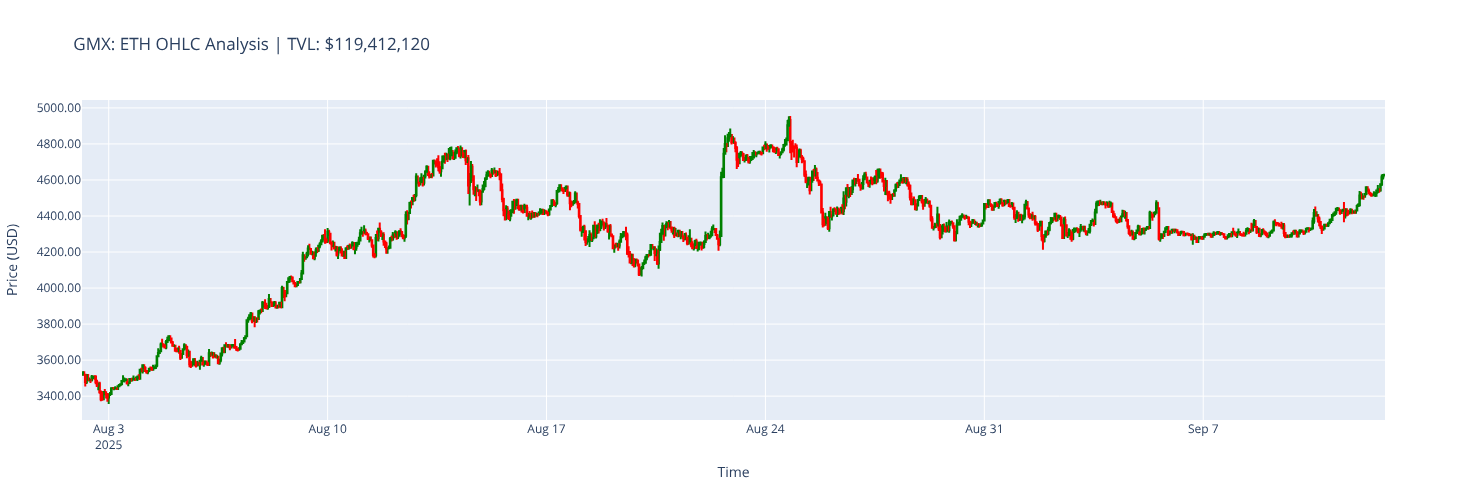

In [10]:
import plotly.graph_objects as go

def create_ohlc_chart(
    df: pd.DataFrame,
    token_symbol: str,
    market_info: dict = None,
    title_suffix: str = ""
) -> go.Figure:
    """
    Create OHLC chart.
    
    :param df: OHLC DataFrame
    :param token_symbol: Token symbol for chart title
    :param market_info: Additional market information
    :param title_suffix: Additional title information
    :return: Plotly figure
    """
    
    if df.empty:
        return None
    
    # Create figure for OHLC only
    fig = go.Figure()
    
    # Add OHLC candlesticks
    fig.add_trace(
        go.Candlestick(
            x=df["timestamp"],
            open=df["open"],
            high=df["high"],
            low=df["low"],
            close=df["close"],
            name="Price",
            increasing_line_color='green',
            decreasing_line_color='red',
            increasing_fillcolor='rgba(0,255,0,0.3)',
            decreasing_fillcolor='rgba(255,0,0,0.3)'
        )
    )
    
    # Prepare title components
    title_parts = [f"GMX: {token_symbol} OHLC Analysis"]
    
    if title_suffix:
        title_parts.append(title_suffix)
    
    # Add TVL information if available
    if market_info and "tvl" in market_info and market_info["tvl"]:
        for market_symbol, tvl_data in market_info["tvl"].items():
            if token_symbol.upper() in market_symbol.upper():
                tvl_value = tvl_data['total_tvl']
                
                # Fix decimal issues common in DeFi data
                if tvl_value > 1e15:  # Likely a decimal precision issue
                    tvl_value = tvl_value / 1e18 if tvl_value > 1e18 else tvl_value / 1e12
                
                # Only show reasonable TVL values
                if 1000 <= tvl_value <= 1e11:
                    title_parts.append(f"TVL: ${tvl_value:,.0f}")
                break
    
    # Update layout
    fig.update_layout(
        title=" | ".join(title_parts),
        height=500,
        showlegend=False,
        xaxis_rangeslider_visible=False,
        yaxis_title="Price (USD)",
        xaxis_title="Time"
    )
    
    fig.update_yaxes(tickformat=".2f")
    
    return fig

# Example usage
fig = create_ohlc_chart(ohlc_df, "ETH", market_info)
fig.show()

## Multi-Token Analysis

For comparative analysis across multiple tokens:

In [ ]:
def analyze_gmx_token_ohlc(
    config: GMXConfig,
    token_symbol: str = "ETH",
    period: str = "1h"
) -> dict:
    """
    Complete OHLC analysis for a GMX token.
    
    :param config: GMX configuration
    :param token_symbol: Token to analyze
    :param period: Time period for candles
    :return: Analysis results
    """
    
    print(f"Analyzing {token_symbol} OHLC data...")
    
    # 1. Get OHLC data from GMX API
    ohlc_df = get_gmx_ohlc_data(config, token_symbol, period)
    
    if ohlc_df.empty:
        print(f"No OHLC data available for {token_symbol}")
        return {}
    
    print(f"Retrieved {len(ohlc_df)} {period} candles")
    
    # 2. Get market information
    market_info = get_gmx_markets_info(config)
    
    # 3. Create OHLC chart
    fig = create_ohlc_chart(ohlc_df, token_symbol, market_info)
    
    # 4. Display chart
    if fig:
        fig.show()
    
    # 5. Print summary statistics
    print(f"\n{token_symbol} OHLC Summary:")
    print(f"Data period: {ohlc_df['timestamp'].min()} to {ohlc_df['timestamp'].max()}")
    print(f"Price range: ${ohlc_df['low'].min():.2f} - ${ohlc_df['high'].max():.2f}")
    print(f"Latest price: ${ohlc_df['close'].iloc[-1]:.2f}")
    
    return {
        "ohlc_data": ohlc_df,
        "market_info": market_info,
        "chart": fig,
        "stats": {
            "price_range": (ohlc_df['low'].min(), ohlc_df['high'].max())
        }
    }

# Example usage
results = analyze_gmx_token_ohlc(config, "ETH", "1h")

def compare_multiple_tokens(config: GMXConfig, tokens: list[str] = ["ETH", "BTC"], period: str = "1h"):
    """Compare OHLC data for multiple tokens."""
    
    results = {}
    
    for token in tokens:
        print(f"\n{'='*50}")
        results[token] = analyze_gmx_token_ohlc(config, token, period)
    
    return results

comparison = compare_multiple_tokens(config, ["ETH", "BTC", "LINK", "ARB"], "1h")

## Complete Example Script

Here's a complete script that puts everything together:

09/13/2025 12:56:48 AM INFO: Created provider lb.drpc.org, using request args {'headers': {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}, 'timeout': (3.0, 30.0)}, headers {'Content-Type': 'application/json', 'User-Agent': 'web3.py/7.12.1/web3.providers.rpc.rpc.HTTPProvider'}
09/13/2025 12:56:48 AM INFO: Configuring MultiProviderWeb3. Call providers: ['lb.drpc.org'], transact providers -
09/13/2025 12:56:48 AM INFO: Successfully added static_call_cache_middleware for web3.py v7


Connected to chain 42161

Data Freshness Check:
Current block: 378,469,052
Analyzing ETH OHLC data...
Retrieved 1000 1h candles


09/13/2025 12:56:55 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:56:56 AM INFO: Performed 90 calls, succeed: 90, failed: 0


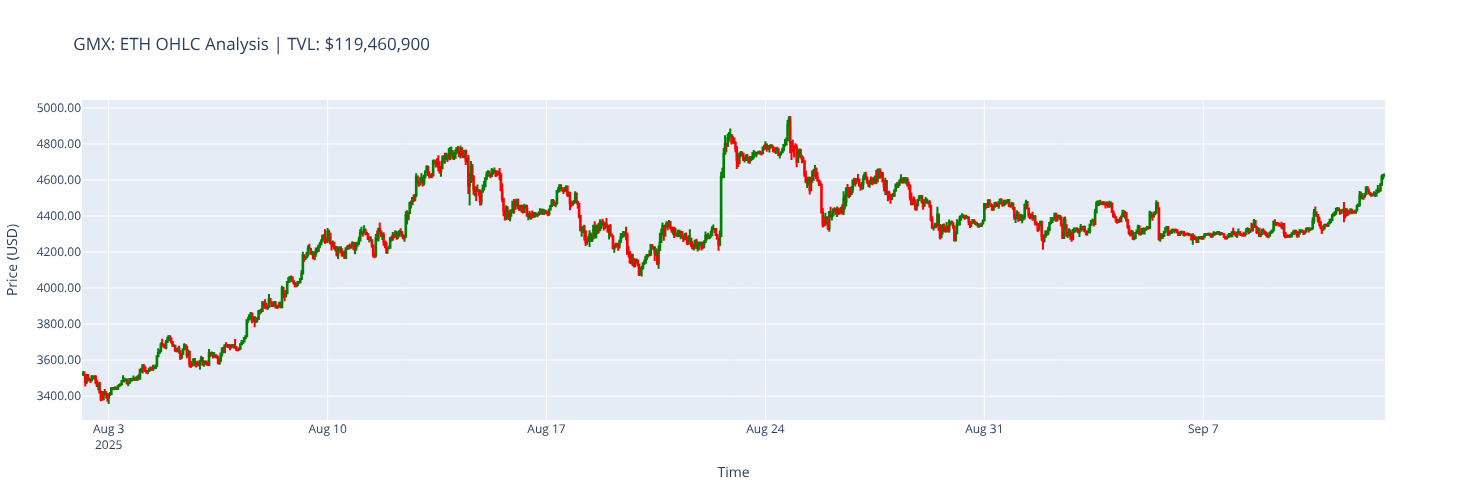


ETH OHLC Summary:
Data period: 2025-08-02 04:00:00 to 2025-09-12 19:00:00
Price range: $3356.45 - $4955.09
Latest price: $3532.40

MULTI-TOKEN COMPARISON

Analyzing LINK OHLC data...
Retrieved 1000 1m candles


09/13/2025 12:57:30 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:57:30 AM INFO: Performed 90 calls, succeed: 90, failed: 0


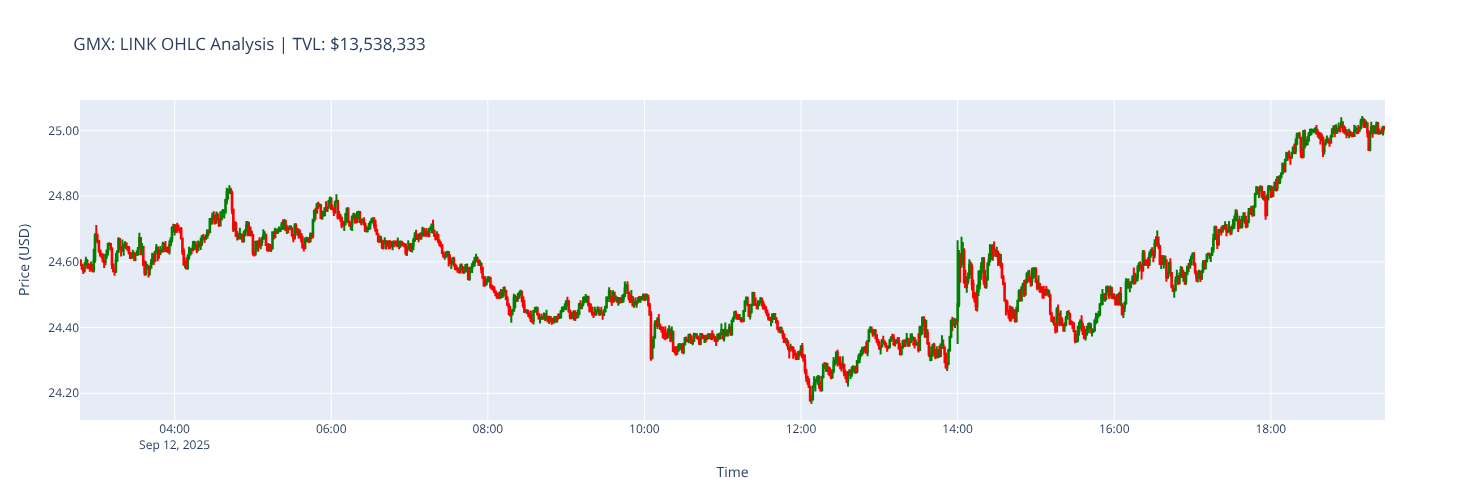


LINK OHLC Summary:
Data period: 2025-09-12 02:48:00 to 2025-09-12 19:27:00
Price range: $24.17 - $25.04
Latest price: $24.59

Analyzing BTC OHLC data...
Retrieved 1000 1m candles


09/13/2025 12:58:09 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:58:10 AM INFO: Performed 90 calls, succeed: 90, failed: 0


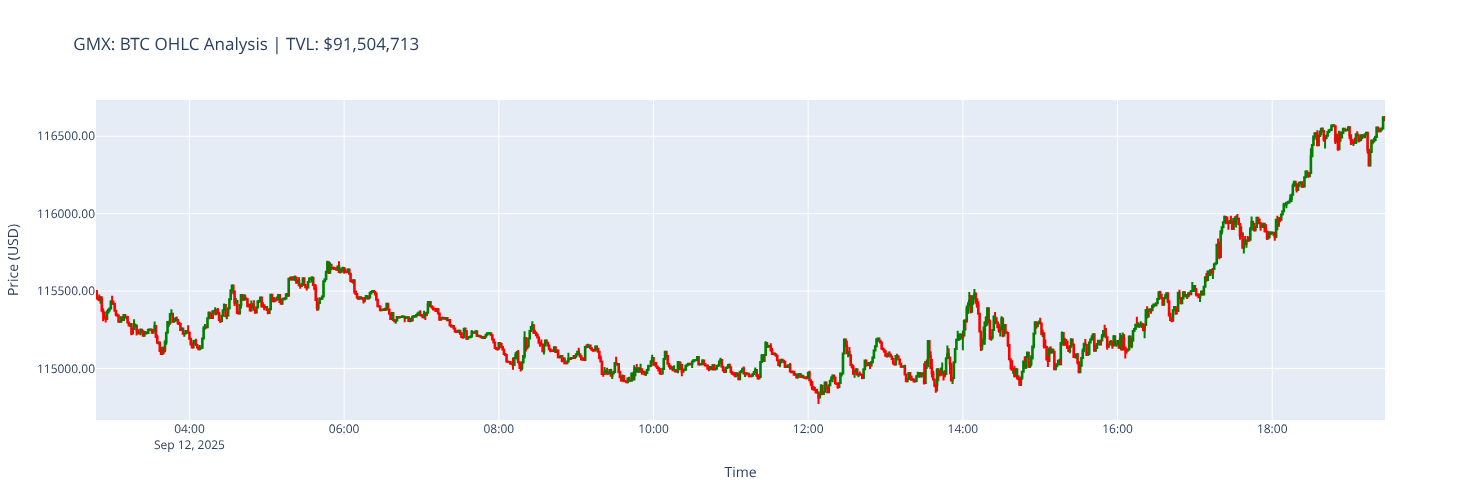


BTC OHLC Summary:
Data period: 2025-09-12 02:48:00 to 2025-09-12 19:27:00
Price range: $114769.84 - $116630.94
Latest price: $115453.20

Analyzing ARB OHLC data...
Retrieved 1000 1m candles


09/13/2025 12:58:47 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:58:48 AM INFO: Performed 90 calls, succeed: 90, failed: 0


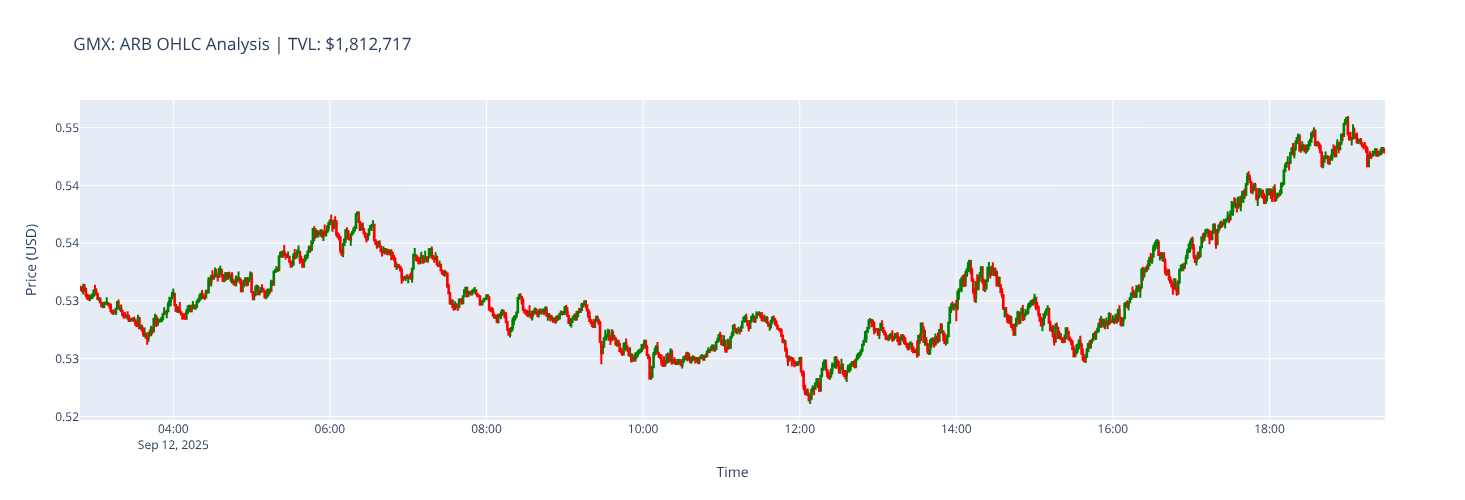


ARB OHLC Summary:
Data period: 2025-09-12 02:49:00 to 2025-09-12 19:28:00
Price range: $0.52 - $0.55
Latest price: $0.53

Analyzing DOGE OHLC data...
Retrieved 1000 1m candles


09/13/2025 12:59:24 AM INFO: About to perform 90 multicalls


Loading pool TVL data:   0%|          | 0/3 [00:00<?, ?it/s]

09/13/2025 12:59:24 AM INFO: Performed 90 calls, succeed: 90, failed: 0


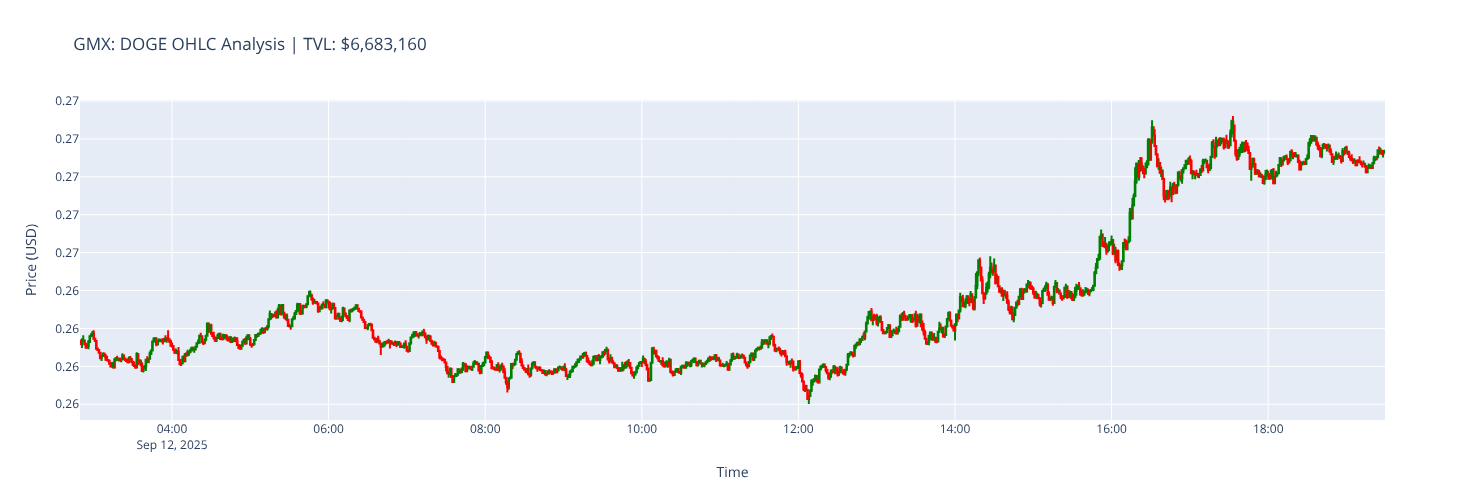


DOGE OHLC Summary:
Data period: 2025-09-12 02:50:00 to 2025-09-12 19:29:00
Price range: $0.26 - $0.27
Latest price: $0.26


In [18]:
import os
import logging
import pandas as pd
import plotly.graph_objects as go

from eth_defi.provider.multi_provider import create_multi_provider_web3
from eth_defi.gmx.config import GMXConfig
from eth_defi.gmx.api import GMXAPI
from eth_defi.gmx.data import GMXMarketData

logger = logging.getLogger(__name__)


def get_gmx_ohlc_data(config: GMXConfig, token_symbol: str = "ETH", period: str = "1h") -> pd.DataFrame:
    """Get OHLC data from GMX API.
    
    :param config: GMX config
    :param token_symbol: Token symbol (ETH, BTC, etc.)
    :param period: Time period (1m, 5m, 15m, 1h, 4h, 1d)
    :return: DataFrame with OHLC data
    """
    
    gmx_api = GMXAPI(config)
    
    # Get raw candlestick data
    raw_data = gmx_api.get_candlesticks(token_symbol, period)
    
    if not raw_data or "candles" not in raw_data:
        return pd.DataFrame()
    
    # Try to extract all available fields
    candles = raw_data["candles"]
    if not candles:
        return pd.DataFrame()
    
    # Determine number of fields in each candle
    num_fields = len(candles[0]) if candles else 0
    
    if num_fields >= 5:
        # At minimum we should have timestamp, open, high, low, close
        columns = ["timestamp", "open", "high", "low", "close"]
        
        df = pd.DataFrame(candles, columns=columns)
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
        
        return df
    
    return pd.DataFrame()


def get_gmx_markets_info(config: GMXConfig) -> dict:
    """Get GMX markets information including TVL and available markets."""
    
    gmx_data = GMXMarketData(config)
    
    # Get available markets
    markets = gmx_data.get_available_markets()
    
    # Get TVL data
    tvl_data = gmx_data.get_pool_tvl()
    
    # Get open interest
    oi_data = gmx_data.get_open_interest()
    
    return {
        "markets": markets,
        "tvl": tvl_data,
        "open_interest": oi_data
    }


def create_ohlc_chart(
    df: pd.DataFrame,
    token_symbol: str,
    market_info: dict = None,
    title_suffix: str = ""
) -> go.Figure:
    """Create OHLC chart.
    
    :param df: OHLC DataFrame
    :param token_symbol: Token symbol for chart title
    :param market_info: Additional market information
    :param title_suffix: Additional title information
    :return: Plotly figure
    """
    
    if df.empty:
        return None
    
    # Create figure for OHLC only
    fig = go.Figure()
    
    # Add OHLC candlesticks
    fig.add_trace(
        go.Candlestick(
            x=df["timestamp"],
            open=df["open"],
            high=df["high"],
            low=df["low"],
            close=df["close"],
            name="Price",
            increasing_line_color='green',
            decreasing_line_color='red',
            increasing_fillcolor='rgba(0,255,0,0.3)',
            decreasing_fillcolor='rgba(255,0,0,0.3)'
        )
    )
    
    # Prepare title components
    title_parts = [f"GMX: {token_symbol} OHLC Analysis"]
    
    if title_suffix:
        title_parts.append(title_suffix)
    
    if market_info:
        if "tvl" in market_info and market_info["tvl"]:
            # Find matching market TVL
            for market_symbol, tvl_data in market_info["tvl"].items():
                if token_symbol.upper() in market_symbol.upper():
                    tvl_value = tvl_data['total_tvl']
                    
                    # Fix obviously wrong TVL values (likely decimal issues)
                    if tvl_value > 1e15:  # If TVL > $1 quadrillion, it's wrong
                        # Try dividing by 1e18 (wei conversion)
                        tvl_value = tvl_value / 1e18
                        if tvl_value > 1e12:  # Still too big, try 1e30
                            tvl_value = tvl_data['total_tvl'] / 1e30
                    
                    # Only show if reasonable (between $1K and $100B)
                    if 1000 <= tvl_value <= 1e11:
                        title_parts.append(f"TVL: ${tvl_value:,.0f}")
                    else:
                        title_parts.append(f"TVL: Debug({tvl_data['total_tvl']:.2e})")
                    break
    
    # Update layout
    fig.update_layout(
        title=" | ".join(title_parts),
        height=500,
        showlegend=False,
        xaxis_rangeslider_visible=False
    )
    
    # Update axes
    fig.update_yaxes(title_text="Price (USD)")
    fig.update_xaxes(title_text="Time")
    
    # Format price axis
    fig.update_yaxes(tickformat=".2f")
    
    return fig


def analyze_gmx_token_ohlc(
    config: GMXConfig,
    token_symbol: str = "ETH",
    period: str = "1h"
) -> dict:
    """Complete OHLC analysis for a GMX token.
    
    :param config: GMX configuration
    :param token_symbol: Token to analyze
    :param period: Time period for candles
    :return: Analysis results
    """
    
    print(f"Analyzing {token_symbol} OHLC data...")
    
    # 1. Get OHLC data from GMX API
    ohlc_df = get_gmx_ohlc_data(config, token_symbol, period)
    
    if ohlc_df.empty:
        print(f"No OHLC data available for {token_symbol}")
        return {}
    
    print(f"Retrieved {len(ohlc_df)} {period} candles")
    
    # 2. Get market information
    market_info = get_gmx_markets_info(config)
    
    # 3. Create OHLC chart
    fig = create_ohlc_chart(ohlc_df, token_symbol, market_info)
    
    # 4. Display chart
    if fig:
        fig.show()
    
    # 5. Print summary statistics
    print(f"\n{token_symbol} OHLC Summary:")
    print(f"Data period: {ohlc_df['timestamp'].min()} to {ohlc_df['timestamp'].max()}")
    print(f"Price range: ${ohlc_df['low'].min():.2f} - ${ohlc_df['high'].max():.2f}")
    print(f"Latest price: ${ohlc_df['close'].iloc[-1]:.2f}")
    
    return {
        "ohlc_data": ohlc_df,
        "market_info": market_info,
        "chart": fig,
        "stats": {
            "price_range": (ohlc_df['low'].min(), ohlc_df['high'].max()),
        }
    }


def compare_multiple_tokens(config: GMXConfig, tokens: list[str] = ["ETH", "BTC"], period: str = "1h"):
    """Compare OHLC data for multiple tokens."""
    
    results = {}
    
    for token in tokens:
        print(f"\n{'='*50}")
        results[token] = analyze_gmx_token_ohlc(config, token, period)
    
    return results


def gmx_ohlc_analysis():
    """Example OHLC analysis."""
    
    # Setup connection
    json_rpc_url = os.environ.get("ARBITRUM_CHAIN_JSON_RPC")
    if not json_rpc_url:
        json_rpc_url = input("Please enter your Arbitrum JSON-RPC URL: ")
    
    web3 = create_multi_provider_web3(json_rpc_url)
    config = GMXConfig(web3)
    
    print(f"Connected to chain {web3.eth.chain_id}")
    
    # Quick freshness check
    print(f"\nData Freshness Check:")
    current_block = web3.eth.block_number
    print(f"Current block: {current_block:,}")
    
    # Single token analysis
    results = analyze_gmx_token_ohlc(config, "ETH", "1h")
    
    # Multiple token comparison
    print(f"\n{'='*60}")
    print("MULTI-TOKEN COMPARISON")
    compare_multiple_tokens(config, ["LINK", "BTC", "ARB", "DOGE"], "1m")
    
    return results


if __name__ == "__main__":
    gmx_ohlc_analysis()

This tutorial provides a foundation for GMX price analysis that can be extended for more sophisticated trading and research applications.